In [1]:
# Семинар 10: гетероскедастичность

import numpy as np
import pandas as pd # чтение файлов
import matplotlib.pyplot as plt # построение графиков
import seaborn as sns # построение графиков
import statsmodels.api as sm # тесты
import statsmodels
import statsmodels.stats.diagnostic as smd # тесты
import statsmodels.formula.api as smf

In [2]:
get_ipython().system('pip install rdatasets') # наборы данных
# !pip install pyreadstat # чтение spss/stata данных
from rdatasets import data
# from pyreadstat import read_sav, set_value_labels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 MB 8.8 MB/s eta 0:00:00


In [3]:
d = pd.read_excel('Heterosk_5.xls')

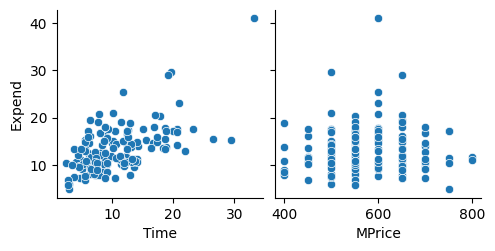

In [4]:
# Построим графики зависимостей затрат от количественных факторов
sns.pairplot(d, x_vars = ["Time", "MPrice"], y_vars = ["Expend"])

In [5]:
reg = smf.ols("Expend ~ Time + MPrice + Age1 + Age2 + Age3 + Age4", d).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     40.37
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           2.15e-28
Time:                        11:10:18   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      1.848      1.822      0.0

In [6]:
# Сохраним прогнозные значения
d['expend_pred'] = reg.predict()
# Сохраним остатки модели
d['resid'] = reg.resid
# Cоздадим переменную resid2 = resid^2
d['resid2'] = reg.resid**2
d

,Time,MPrice,Expend,Age1,Age2,Age3,Age4,Age5,expend_pred,resid,resid2
0,6.7,550,9.0,0,0,0,1,0,9.505400,-0.505400,0.255429
1,5.4,600,7.6,0,0,1,0,0,14.185975,-6.585975,43.375073
2,7.2,650,7.8,0,0,0,0,1,9.937136,-2.137136,4.567348
3,14.2,700,14.0,1,0,0,0,0,14.944859,-0.944859,0.892758
4,6.4,650,19.5,0,0,1,0,0,14.915321,4.584679,21.019277
...,...,...,...,...,...,...,...,...,...,...,...
144,7.6,750,10.4,0,0,0,1,0,10.866090,-0.466090,0.217240
145,13.2,600,11.2,0,0,0,1,0,12.996623,-1.796623,3.227855
146,10.5,650,7.3,0,0,0,1,0,11.867979,-4.567979,20.866433
147,7.6,650,9.0,0,0,0,0,1,10.137999,-1.137999,1.295042


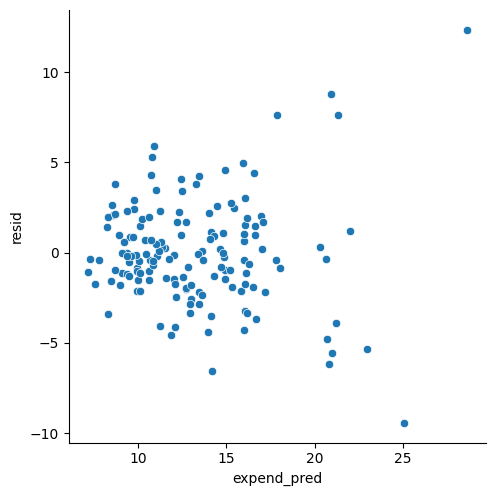

In [7]:
# Построим график зависимости остатков модели от прогнозных значений
sns.pairplot(d, x_vars=['expend_pred'], y_vars=["resid"], height = 5)

In [8]:
X = d[["Time", "MPrice", "Age1", "Age2", "Age3", "Age4"]]
X = sm.add_constant(X) # добавим столбец из 1 в матрицу X, чтобы включить константу

# Тест Уайта
print(smd.het_white(resid = d['resid'], exog = X)[:2])

(93.7411676846798, 1.266689712399042e-12)


In [9]:
# Тест Бройша-Пагана (зависимость дисперсии от конкретных факторов)

BP_test = smd.het_breuschpagan(resid=d['resid'], exog_het=X)
from statsmodels.compat import lzip
print(pd.DataFrame(lzip(['LM statistic', 'p-value',  'F-value', 'F: p-value'], BP_test)[:2]))

# Первое из выданных значений - значение тестовой статистики теста Бройша - Пагана, второе - значение p-value для выданной тестовой
# статистики.
# Третье и четвёртое - значения тестовой статистики и её p-value для на уровне значимости 5% (табличное).
# Вывод: так как p-value=0 < 0.05, то гипотеза H1 не отвергается, то есть етероскедастичность присутствует.

              0             1
0  LM statistic  4.924961e+01
1       p-value  6.645600e-09


In [12]:
# Способ корректировки гетероскедастичности - использование робастных оценок, например, в форме Уайта.

reg_robust = reg.get_robustcov_results(cov_type = 'HC3')
print(reg_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 Expend   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     13.23
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           7.21e-12
Time:                        11:13:42   Log-Likelihood:                -370.85
No. Observations:                 149   AIC:                             755.7
Df Residuals:                     142   BIC:                             776.7
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3682      2.044      1.647      0.1